# Project 1 - Regression

In this project we will apply the regression methods, Linear regression and K-Nearest neighbors regression. We will use the California housing dataset which contains information about house prices in California during the 1990s. The regression task is to predict the median house price (target variable) based on a number of descriptive variables (features) such as the house location and the number of bedrooms.

We will start by importing some useful Python libraries and functions to help us out.

In [68]:
import pandas as pd # Used to construct a DataFrame to hold the data.
import numpy as np

from sklearn.datasets import fetch_california_housing  # Used to load the dataset
from sklearn.linear_model import LinearRegression      # Linear Regression model
from sklearn.neighbors import KNeighborsRegressor      # KNN Regression model

# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Exploratory Data Analysis

We are now ready to load the dataset. Before applying any regression model we need to understand the dataset we are working with. In particular, we need to know what each row/instance in our dataset represents and we need to understand each of the features. For that reason we print a dataset description below. Make sure to read and understand it before proceeding.

In [5]:
cali_dataset = fetch_california_housing(as_frame=True) # Loads dataset
print(cali_dataset.DESCR)                              # Prints dataset description

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Lets have a look at the first 5 rows in our DataFrame to get a better idea of what we are working with.

In [6]:
cali_dataframe = cali_dataset.frame 
cali_dataframe.head(5) # Shows first 5 rows of the DataFrame

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We can also look at the linear correlation between the variables in our dataset. This is useful to get a general understanding of how the variables relate to each other. The linear correlation is a number between -1 (strong negative correlation) and 1 (strong positive correlation) which tells us about the linear relationship between two variables. A correlation of 0 means that there is no linear dependence between the variables. The image below gives an intuitive understanding of what the linear correlation tells us about the data.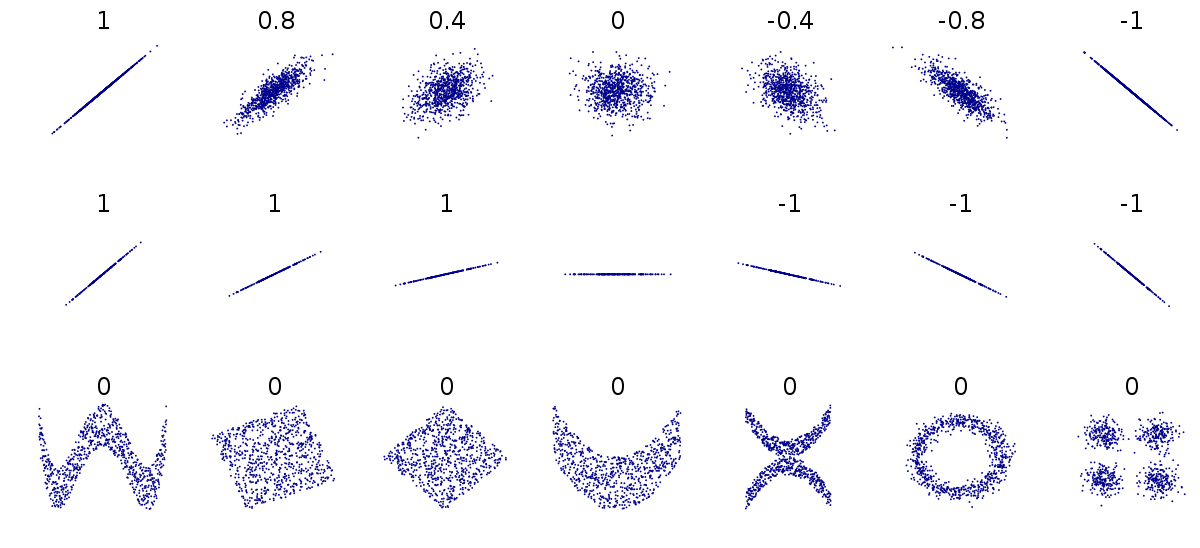

Below we create a correlation heatmap for the california dataset.

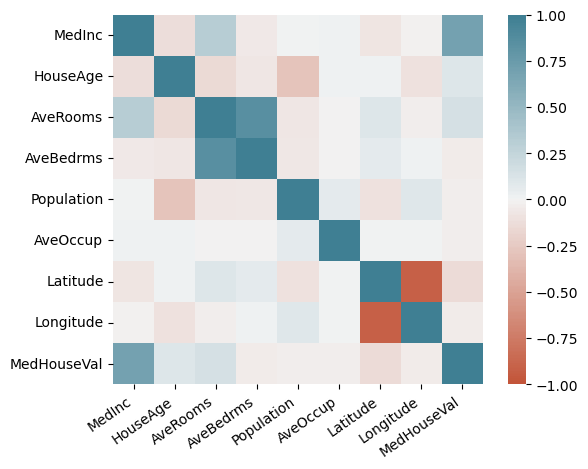

In [7]:
corr = cali_dataframe.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, horizontalalignment='right');

From this plot we can see some of the structure in the data. The only feature that shows a significant linear correlation with the target variable is the median household income. Does this mean that the other features do not provide any information about the median house value? The answer is no because even if there is no linear correlation the variables can be related in other non-linear ways (see the bottom row in the correlation examples image above). To see this lets look at how the target variable relates to the features by plotting pairwise scatterplots with the median house value on the y-axis and the features on the x-axis. We obtain one plot per feature in this way as we can see below.

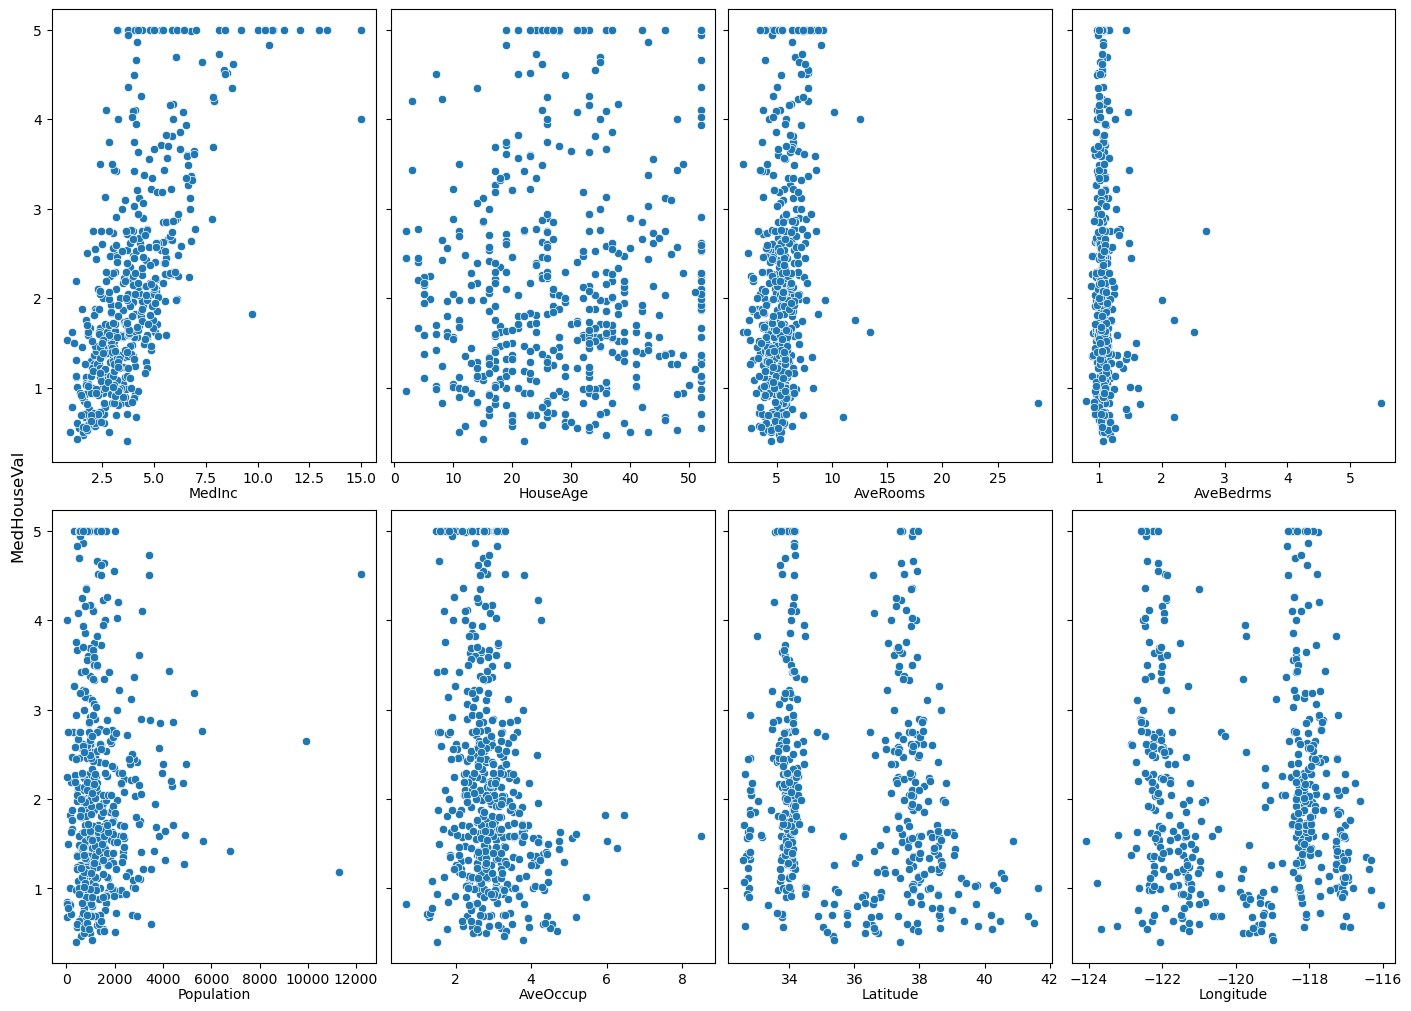

In [8]:
cali_dataframe_sample = cali_dataframe.sample(n=500) # Collects a sub-sample of the data for clear plotting

f, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 10), constrained_layout=True)
for i, coord in enumerate([(j, k) for j in range(2) for k in range(4)]):
    var = cali_dataframe_sample.iloc[:, i].name
    if var != 'MedHouseVal':
        sns.scatterplot(x=var, y='MedHouseVal', data=cali_dataframe_sample, ax=axs[coord])
        axs[coord].xaxis.labelpad = 0.5
        axs[coord].set_ylabel('')
f.supylabel('MedHouseVal');

From the scatterplots we see more detail compared to the correlation heatmap. In particular, we see that even though the house location (latitude and longitude) is not linearly correlated with the median house value there is still a clear relationship between these variables. We see two peaks in the plots of the latitude and longitude which correspond to two locations where the median house value is higher. Do you know which locations these peaks correspond to? <strong>Hint:</strong> Use Google Maps!

## Data Preprocessing

From the scatterplots we also see that there are a lot of values bunched up at the top when MedHouseVal = 5. This is because the dataset is capped so that any median house value at or above 5 is simply set to 5. This causes a threshold effect which may negatively impact our regression analysis. For this reason we will simplify the regression task to only consider instances for which MedHouseVal < 5.

In [63]:
cali_dataframe = cali_dataframe[cali_dataframe['MedHouseVal'] < 5] # Removing data points at threshold
cali_dataframe

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [66]:
data_X = cali_dataframe.iloc[:,-2:]
data_X

,Longitude,MedHouseVal
0,-122.23,4.526
1,-122.22,3.585
2,-122.24,3.521
3,-122.25,3.413
4,-122.25,3.422
...,...,...
20635,-121.09,0.781
20636,-121.21,0.771
20637,-121.22,0.923
20638,-121.32,0.847


Before applying any supervised learning method we must split our data into a training set which we use to fit our model and a test set which we use to evaluate the performance of the model on unseen data. We will set aside 10% of the data as the test set which can be done easily with the function `train_test_split`. Since we need to choose the number of nearest neighbors k for KNN regression we also need to set aside a validation set of the training data that we will use to determine the optimal value for k. Note that we cannot use the test set for this since the test set should only be used to evaluate performance on unseen data. If we use the test set to choose k the model has already "seen" the test data during training which defeats the purpose of a test set. We will set aside 10% of the training set as the validation set by once again using the function `train_test_split`.

We will also separate the features and the target variable to easily fit the models later. Lastly, we will standardize the features which is an important step before applying KNN regression. To understand why and how we standardize I refer you to the last chapter of section 2.2 in the SML book (https://smlbook.org/) titled "Input Normalisation". We use equation (2.2) from this chapter to standardize the features.

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train, test = train_test_split(cali_dataframe, test_size=0.1, random_state=1234) # Splitting data into train and test
train, validation = train_test_split(train, test_size=0.1, random_state=1234) # Splitting train into train and validation

train_X = train.drop('MedHouseVal', axis=1) # Features in the training set
train_y = train['MedHouseVal'] # Target in the training set

validation_X = validation.drop('MedHouseVal', axis=1) # Features in the validation set
validation_y = validation['MedHouseVal'] # Target in the validation set

test_X = test.drop('MedHouseVal', axis=1) # Features in the test set
test_y = test['MedHouseVal'] # Target in the test set


# Standardizing features (equation 2.2 in sml)
standardizer = StandardScaler()
train_X = standardizer.fit_transform(train_X)
validation_X = standardizer.transform(validation_X)
test_X = standardizer.transform(test_X)

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
13396  4.6727       5.0  5.395331   1.020233      3845.0  2.992218     34.02   
2402   2.6058      26.0  5.789157   1.021084      1148.0  3.457831     36.62   
2404   1.7292      33.0  4.513678   1.136778      1544.0  4.693009     36.62   
13696  3.4138      14.0  6.012030   1.069173      1509.0  2.269173     34.13   
20142  1.8618      52.0  4.157718   1.073826       934.0  3.134228     34.36   
...       ...       ...       ...        ...         ...       ...       ...   
11854  2.2717      18.0  5.520259   1.090762      1567.0  2.539708     39.83   
6662   4.0000      52.0  5.142857   0.980769       984.0  2.703297     34.16   
8070   3.8350      43.0  4.769088   1.013035      1063.0  1.979516     33.84   
6713   7.9213      44.0  6.448113   0.978774      1057.0  2.492925     34.13   
20277  4.4292      17.0  4.950966   1.132244      1797.0  2.670134     34.18   

       Longitude  
13396    -117.57  
2

## Linear Regression

We will now apply linear regression to predict the median house value (MedHouseVal) using the features in the dataset. We will use the `LinearRegression` class from the library `sklearn`. To solve the exercise you will need to understand how this class works by reading the documentation which can be found here https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.


<strong>Task 1:</strong> Fit a Linear regression model to the training set using the `fit` method of the `LinearRegression` class. Save the result to a variable called `linreg`.

In [11]:
linreg = LinearRegression()
linreg.fit(train_X, train_y)

LinearRegression()

<strong>Task 2:</strong> Use the Linear regression model that you trained in the previous task to predict the target values from the test features using the `predict` method of the `LinearRegression` class. Save the result to a variable called `y_pred_linreg`.

In [13]:
y_pred_linreg = linreg.predict(test_X)
y_pred_linreg

#Coefficients
print(linreg.coef_)
#intercepts
print(linreg.intercept_)

[ 0.67475579  0.1001921  -0.24240975  0.26867921  0.00949846 -0.03703724
 -0.80761277 -0.78536276]
1.9175312284780701


<strong>Task 3:</strong> Write a function that plots the predicted target values against the true target values in a scatterplot. Also plot the line y=x in this plot as a reference to show what a perfect prediction would look like, i.e., when the predicted values are exactly equal to the true values. <strong>Hint:</strong> Use the `matplotlib` functions `plot` and `scatter`.

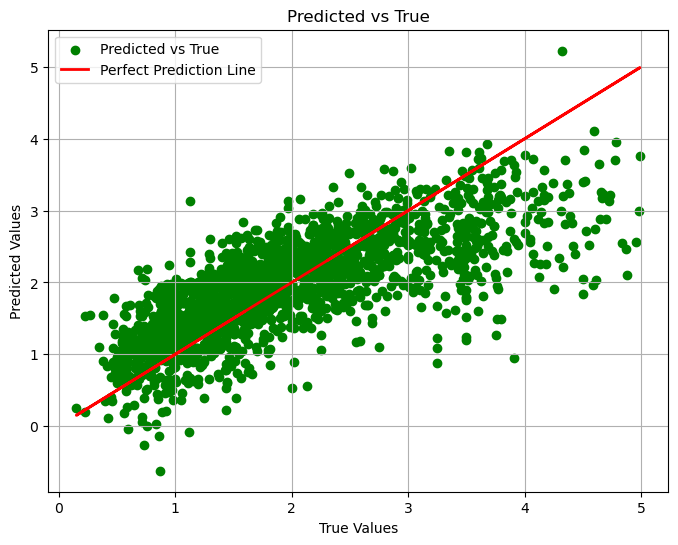

In [24]:
def plot_predicted_vs_true(y_pred, y_true):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, color='green', label='Predicted vs True')
    plt.plot(y_true, y_true, color='red', linestyle='-', linewidth=2, label='Perfect Prediction Line')
    plt.title('Predicted vs True')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predicted_vs_true(y_pred_linreg, test_y)

What do you see in this plot? Do the predicted values seem to match up well with the true values?

Before moving on we will also compute the mean absolute error (MAE) between the predicted values and the true values to get a better idea of how large the errors are. Let $r_i = y_i - \hat{y}_i$ denote the residual of data point $i$, i.e., the difference between the true value of the target variable ($y_i$) and its predicted value ($\hat{y}_i$). Then with a total of $n$ data points the MAE is given by,
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |r_i|.
$$
<strong>Task 4:</strong> Write a function that computes the MAE given the predicted target values and the true values. Use the function to compute the test set MAE of your linear regression model. What is the test set MAE of your linear regression model in terms of US dollars?

In [35]:
def mean_absolute_error(y_pred, y_true):
    return (y_pred - y_true).abs().mean()

mae_linreg = mean_absolute_error(y_pred_linreg, test_y)
print('Test set MAE for Linear Regression:', mae_linreg)

Test set MAE for Linear Regression: 0.4763342616886403


...

## K-Nearest Neighbors Regression




The main disadvantage of Linear regression is that it is limited to capturing linear relationships between the target variable and the features. As we have already seen some of the features in our dataset are related to the target variable in non-linear ways. K-Nearest Neighbors (KNN) regression offers a more flexible framework for regression that allows us to capture non-linear relationships. In contrast to Linear Regression we also have a user defined parameter (hyperparameter) k in KNN regression which needs to be determined before applying the method. 

In this task we will use the `KNeighborsRegressor` class from `sklearn`. The documentation for this class can be found here https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html. We will use the euclidean distance to find nearest neighbors which is the default distance metric for this class.

<strong>Task 5:</strong> Finish the function `fit_predict_knn`. The function should fit a KNN-regression model to the training set and return the predicted target values from the validation features. The function is outlined below and takes the training set, the validation features and $k$ as inputs.

In [37]:
def fit_predict_knn(train_X, train_y, validation_X, k):
    KNNreg = KNeighborsRegressor(n_neighbors=k) #Create KNNreg variable using KNN-reg model
    
    KNNreg.fit(train_X, train_y) # Fit KNN regressor to the training data train_X, train_y
    
    y_pred_KNNreg = KNNreg.predict(validation_X) # Predict target values for the validation X
    

    return y_pred_KNNreg

Before arriving at our final KNN-regression model we need to determine the optimal value for k, the number of nearest neighbors. We will evaluate the performance of the KNN-regression model on the validation set for different values of k to find the optimal value.

<strong>Task 6:</strong> Calculate the validation set MAE of KNN-regression for values of $k$ from 1 to 30. Then create a plot with $k$ on the x-axis and the MAE on the y-axis showing how the MAE changes as we increase $k$.

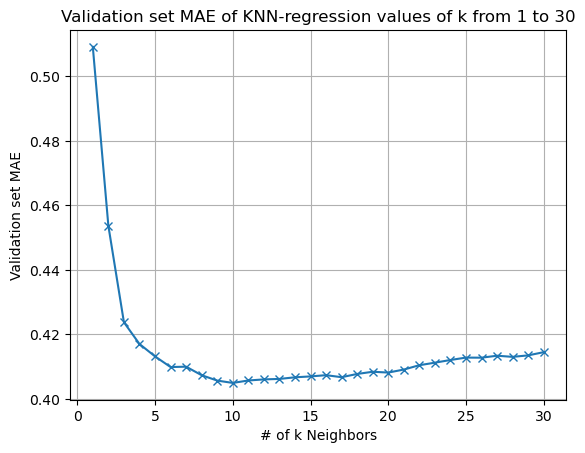

In [52]:
k_val = range(1, 31)

mae_val = []


for k in k_val: # Iterate over each value of k
    y_pred = fit_predict_knn(train_X, train_y, validation_X, k) # Predict target values for validation set using KNN regression
    
    # Calculate MAE for the predicted values
    mae = mean_absolute_error(y_pred, validation_y)# using the MAE function defined before
    
    mae_val.append(mae)

# Plot k vs MAE
plt.plot(k_val, mae_val, marker='x', linestyle='-')
plt.title("Validation set MAE of KNN-regression values of k from 1 to 30")
plt.xlabel('# of k Neighbors')
plt.ylabel('Validation set MAE')
plt.xticks(k_val)
plt.grid(True)
plt.show()



<strong>Task 7:</strong> Explain the plot above in terms of the bias-variance tradeoff. Does increasing k increase or decrease the model complexity? What value of k seems to be optimal in this case? Store the optimal value in the variable `optimal_k`

...

In [74]:
optimal_k = 10


One of the disadvantages of KNN regression is that it treats all features as equally important when computing distances between neighbors. This causes problems when we have some features that are important and others that provide very little information about the target variable. For example we know from our exploratory analysis that house age does not seem to provide any information about the median house value. Consequently, two instances that are close in house age are not necessarily close in median house value. Therefore, treating these instances as nearest neighbors will lead to poor predictions.

To make sure that we are only using important information in our KNN regression we will remove all features except latitude and longitude which provide only location information. We know that location is important in determining median house value from our previous analysis. By only using location information the regression model becomes very simple and easy to intepret. To determine the median house value of a new block group we simply average the median house values of the k geographically closest block groups. 

Lets see how this change affects the results of our regression model.

<strong>Task 8:</strong> Recreate the plot from task 6 but this time by only using latitude and longitude as features in the model. Does this change seem to improve the results? Store the optimal k value for the location only data in the variable `optimal_k_loc`. 

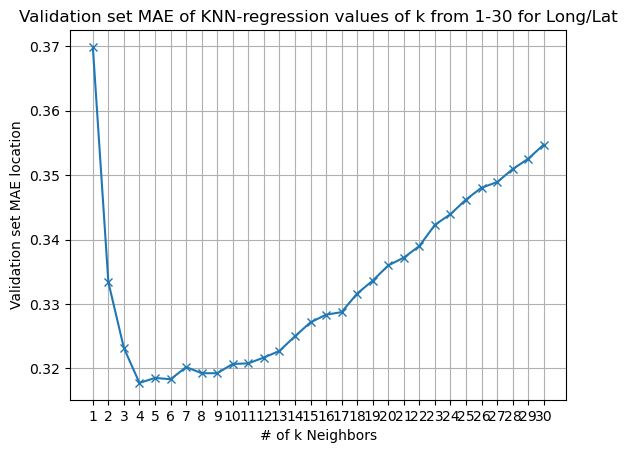

In [70]:
#New selected data set variables for training
train_X_loc = train_X[:,-2:]
validation_X_loc = validation_X[:,-2:]
test_X_loc = test_X[:,-2:]


#Retrain model and save to new MAE location variable:
mae_val_loc = []


for k in k_val: # Iterate over each value of k_val from before 
    y_pred = fit_predict_knn(train_X_loc, train_y, validation_X_loc, k) # Predict target values for validation set using KNN regression
    
    # Calculate MAE for the predicted values
    mae = mean_absolute_error(y_pred, validation_y)# using the MAE function defined before
    
    mae_val_loc.append(mae)

# Plot k vs MAE location
plt.plot(k_val, mae_val_loc, marker='x', linestyle='-')
plt.title("Validation set MAE of KNN-regression values of k from 1-30 for Long/Lat")
plt.xlabel('# of k Neighbors')
plt.ylabel('Validation set MAE location')
plt.xticks(k_val)
plt.grid(True)
plt.show()

In [79]:
optimal_k_loc = 4

## Final Model Evaluation

Finally, lets compare the regression models that we have considered so far in terms of their mean absolute error on the unseen data in the test set.

In [80]:
y_pred_KNNreg = fit_predict_knn(train_X, train_y, test_X, optimal_k)
mae_KNNreg = mean_absolute_error(y_pred_KNNreg, test_y) 

y_pred_KNNreg_loc = fit_predict_knn(train_X_loc, train_y, test_X_loc, optimal_k_loc)
mae_KNNreg_loc = mean_absolute_error(y_pred_KNNreg_loc, test_y) 
                                    
print('Test set MAE for Linear Regression:', mae_linreg)
print('Test set MAE for KNN Regression:', mae_KNNreg)
print('Test set MAE for KNN Regression with location only data:', mae_KNNreg_loc)

Test set MAE for Linear Regression: 0.4763342616886403
Test set MAE for KNN Regression: 0.40836565292620863
Test set MAE for KNN Regression with location only data: 0.30993588167938935
